In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import AutoARIMA, ARIMA
from darts.metrics import mape, rmse, mase
from darts.dataprocessing.transformers import Scaler
from darts.utils.model_selection import train_test_split

import optuna

/Users/nataliiaremezova/Documents/Workspace/BHT/SoSe2025/DSApps2/project/BerlinWeatherTimeSeriesAnalysis/.venv/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/Users/nataliiaremezova/Documents/Workspace/BHT/SoSe2025/DSApps2/project/BerlinWeatherTimeSeriesAnalysis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_files = ["../data/2023_BME680SensorData.csv", "../data/2024_BME680SensorData.csv"]
test_file = "../data/2025_BME680SensorData.csv"

In [3]:
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]

def impute_neighbor_avg(s: pd.Series) -> pd.Series:
    filled = s.where(s.notna(), (s.shift(1) + s.shift(-1)) / 2)
    return filled.ffill().bfill()


def preprocess(files):
    # concatenate and index by time
    dfs = []
    for fn in files:
        df = pd.read_csv(fn, usecols=columns, parse_dates=["ISO Time"]).set_index("ISO Time").sort_index()
        dfs.append(df)
    raw = pd.concat(dfs)

    # ensure complete minute index
    full_idx = pd.date_range(raw.index.min(), raw.index.max(), freq="T")
    raw = raw.reindex(full_idx)

    # impute missing
    for col in columns[1:]:
        raw[col] = impute_neighbor_avg(raw[col])

    # hourly aggregation
    return raw.resample("H").mean()

# preprocess training and test
hourly_train = preprocess(train_files)
hourly_test  = preprocess([test_file])

# focus on Temperature
train_series = TimeSeries.from_series(hourly_train["Temperature (C)"])
test_series  = TimeSeries.from_series(hourly_test[ "Temperature (C)"])

/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_65933/3122216588.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(raw.index.min(), raw.index.max(), freq="T")
/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_65933/3122216588.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return raw.resample("H").mean()
/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_65933/3122216588.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_idx = pd.date_range(raw.index.min(), raw.index.max(), freq="T")
/var/folders/7r/8tzl4xz922146pgx3szt94t80000gn/T/ipykernel_65933/3122216588.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return raw.resample("H").mean()


In [4]:
model_auto = AutoARIMA()
model_auto.fit(train_series)
pred_auto = model_auto.predict(len(test_series))

print("AutoARIMA on 2023–24 → 2025 Test")
print("MAPE:", mape(test_series, pred_auto))
print("RMSE:", rmse(test_series, pred_auto))
print("MASE:", mase(test_series, pred_auto, train_series))

AutoARIMA on 2023–24 → 2025 Test
MAPE: 259.38797061378096
RMSE: 10.263237552628464
MASE: 19.39224019715871


In [6]:
breakpoint = int(len(train_series) * 0.8)
start_ts = train_series.time_index[breakpoint]


def objective(trial):
    p = trial.suggest_int('p', 0, 3)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 3)
    try:
        model = ARIMA(order=(p, d, q))
        # backtest returns predictions aligned with history from start_ts
        backtest_pred = model.backtest(
            series=train_series,
            start=start_ts,
            forecast_horizon=24,
            stride=24,
            verbose=False
        )
        actual = train_series.slice(start_ts)
        return rmse(actual, backtest_pred)
    except Exception:
        return float('inf')

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
print("Best ARIMA params:", study.best_params)

[I 2025-07-03 23:03:33,847] A new study created in memory with name: no-name-a3e73f9c-7aee-40bc-87c9-1d1ada6ab128
[I 2025-07-03 23:03:33,858] Trial 0 finished with value: inf and parameters: {'p': 2, 'd': 0, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-07-03 23:03:33,859] Trial 1 finished with value: inf and parameters: {'p': 0, 'd': 0, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-07-03 23:03:33,860] Trial 2 finished with value: inf and parameters: {'p': 2, 'd': 2, 'q': 1}. Best is trial 0 with value: inf.
[I 2025-07-03 23:03:33,860] Trial 3 finished with value: inf and parameters: {'p': 2, 'd': 1, 'q': 0}. Best is trial 0 with value: inf.
[I 2025-07-03 23:03:33,861] Trial 4 finished with value: inf and parameters: {'p': 0, 'd': 2, 'q': 2}. Best is trial 0 with value: inf.
[I 2025-07-03 23:03:33,862] Trial 5 finished with value: inf and parameters: {'p': 1, 'd': 2, 'q': 3}. Best is trial 0 with value: inf.
[I 2025-07-03 23:03:33,862] Trial 6 finished with value: inf and param

Best ARIMA params: {'p': 2, 'd': 0, 'q': 3}


In [8]:
bp = study.best_params
best_arima = ARIMA(p=bp['p'], d=bp['d'], q=bp['q'])
best_arima.fit(train_series)

pred_arima = best_arima.predict(len(test_series))
print("ARIMA(p,d,q) Test Results")
print("MAPE:", mape(test_series, pred_arima))
print("RMSE:", rmse(test_series, pred_arima))
print("MASE:", mase(test_series, pred_arima, train_series))

ARIMA(p,d,q) Test Results
MAPE: 1078.7194527365307
RMSE: 7.472889223630581
MASE: 14.437269589545311


In [15]:
# Compute scalar mean of the training series for the baseline
mean_val = train_series.values().mean()  # numpy scalar mean
# Build a pandas Series of the constant mean, indexed by the test time index
import pandas as pd
mean_series = pd.Series(mean_val, index=test_series.time_index)
# Convert to a Darts TimeSeries
pred_mean = TimeSeries.from_series(mean_series)

print("Mean-Baseline Results")
print("MAPE:", mape(test_series, pred_mean))
print("RMSE:", rmse(test_series, pred_mean))
print("MASE:", mase(test_series, pred_mean, train_series))

Mean-Baseline Results
MAPE: 1102.425324710258
RMSE: 7.686043629306789
MASE: 14.946065100809856


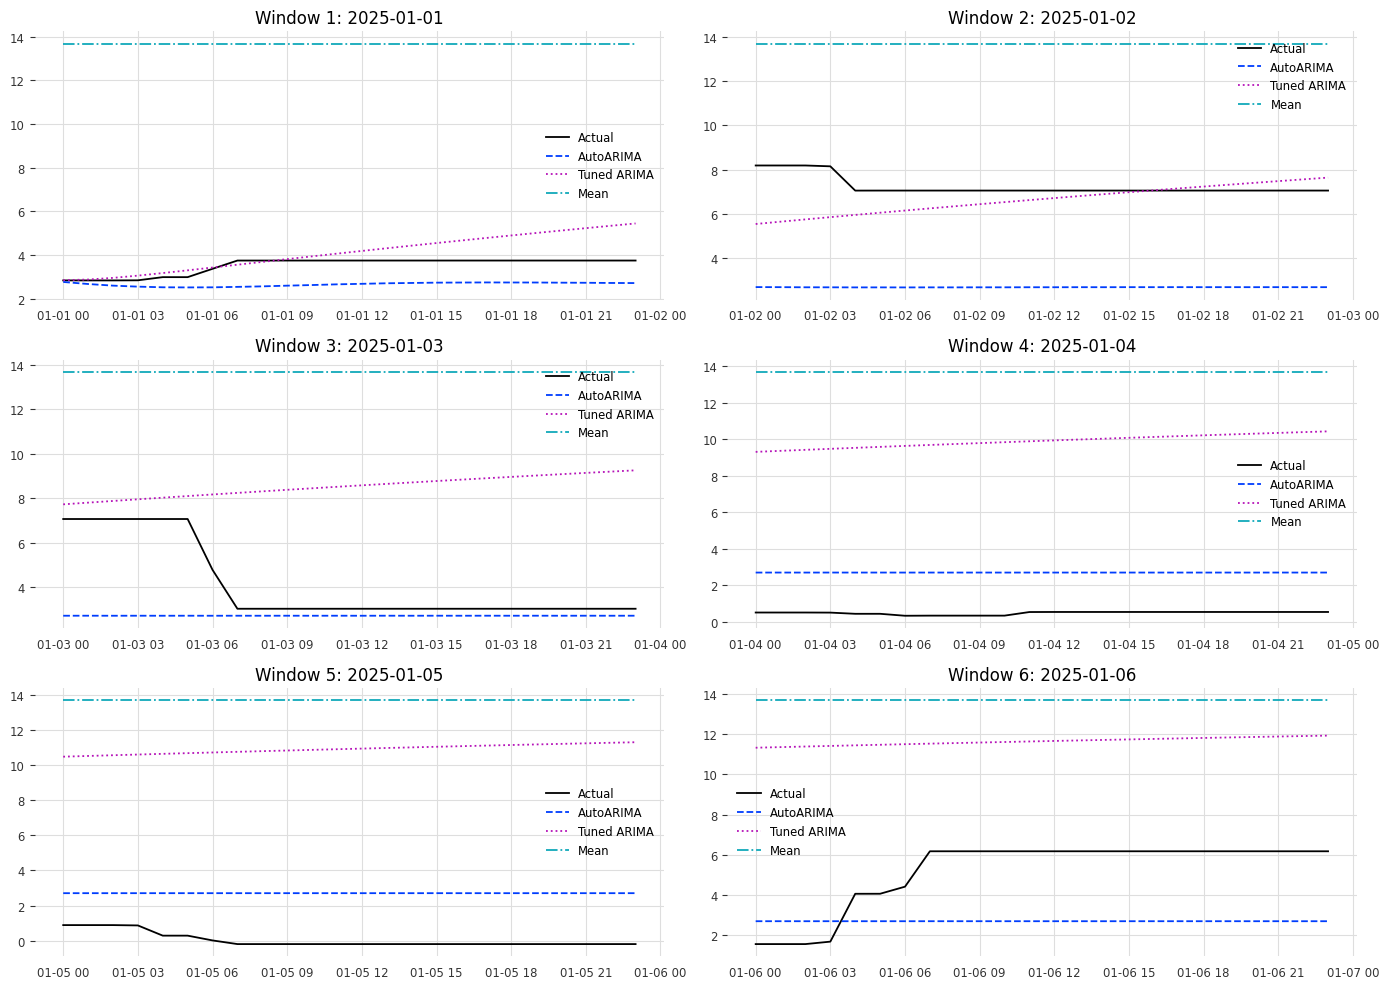

In [19]:
horizon = 24
num_windows = 6

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
axes = axes.flatten()

for i in range(num_windows):
    start_idx = i * horizon
    end_idx = start_idx + horizon
    t_idx = test_series.time_index[start_idx:end_idx]
    actual = test_series.values()[start_idx:end_idx].flatten()
    auto_pred = pred_auto.values()[start_idx:end_idx].flatten()
    arima_pred = pred_arima.values()[start_idx:end_idx].flatten()
    mean_pred = pred_mean.values()[start_idx:end_idx].flatten()

    ax = axes[i]
    ax.plot(t_idx, actual, label='Actual')
    ax.plot(t_idx, auto_pred, '--', label='AutoARIMA')
    ax.plot(t_idx, arima_pred, ':', label='Tuned ARIMA')
    ax.plot(t_idx, mean_pred, '-.', label='Mean')
    ax.set_title(f"Window {i+1}: {t_idx[0].strftime('%Y-%m-%d')}")
    ax.legend(fontsize='small')

plt.tight_layout()
plt.show()